In [1]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Concatenate
from tensorflow import convert_to_tensor
from math import floor, ceil

import pickle
import tensorflow as tf
import numpy as np

class GAN:
    """ Generative adverserial network class.

    Training code for a standard DCGAN using the Adam optimizer.
    Code taken in part from: https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb
    """    

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.loss(tf.ones_like(real_output), real_output)
        fake_loss = self.loss(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.loss(tf.ones_like(fake_output), fake_output)

    def __init__(self, discriminator, generator, training_input, lr_d=1e-4, lr_g=3e-4, epsilon=1e-8, beta_1=.0, beta_2=0.9, from_logits=True):
        """Create a GAN instance

        Args:
            discriminator (tensorflow.keras.models.Model): Discriminator model.
            generator (tensorflow.keras.models.Model): Generator model.
            training_input (int): input size of temporal axis of noise samples.
            lr_d (float, optional): Learning rate of discriminator. Defaults to 1e-4.
            lr_g (float, optional): Learning rate of generator. Defaults to 3e-4.
            epsilon (float, optional): Epsilon paramater of Adam. Defaults to 1e-8.
            beta_1 (float, optional): Beta1 parameter of Adam. Defaults to 0.
            beta_2 (float, optional): Beta2 parameter of Adam. Defaults to 0.9.
            from_logits (bool, optional): Output range of discriminator, logits imply output on the entire reals. Defaults to True.
        """
        self._paramaters = [training_input, lr_d, lr_g, epsilon, beta_1, beta_2, from_logits]
        self.discriminator = discriminator
        self.generator = generator
        self.noise_shape = [self.generator.input_shape[1], training_input, self.generator.input_shape[-1]]

        self.loss = BinaryCrossentropy(from_logits=from_logits)

        self.generator_optimizer = Adam(lr_g, epsilon=epsilon, beta_1=beta_1, beta_2=beta_2)
        self.discriminator_optimizer = Adam(lr_d, epsilon=epsilon, beta_1=beta_1, beta_2=beta_2)

    def train(self, data, batch_size, n_batches, additional_d_steps):
        """training function of a GAN instance.
        Args:
            data (4d array): Training data in the following shape: (samples, n_series, timesteps, 1).
            batch_size (int): Batch size used during training.
            n_batches (int): Number of update steps taken.
            additional_d_steps (int): Number of extra discriminator training steps during each update.
        """ 
        progress = Progbar(n_batches)

        for n_batch in range(n_batches):
            # sample uniformly
            batch_idx = np.random.choice(np.arange(data.shape[0]), size=batch_size, replace=(batch_size > data.shape[0]))
            batch = data[batch_idx]
            
            self.train_step(batch, batch_size, additional_d_steps)

            self.train_hook(n_batch)

            progress.update(n_batch + 1)

    @tf.function
    def train_step(self, data, batch_size, additional_d_steps):

        for _ in range(additional_d_steps + 1):
            noise = tf.random.normal([batch_size, *self.noise_shape])
            generated_data = self.generator(noise, training=False)

            with tf.GradientTape() as disc_tape:
                real_output = self.discriminator(data, training=True)
                fake_output = self.discriminator(generated_data, training=True)
                disc_loss = GAN.discriminator_loss(real_output, fake_output)
            
            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
            self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        noise = tf.random.normal([batch_size, *self.noise_shape])
        generated_data = self.generator(noise, training=False)
        
        noise = tf.random.normal([batch_size, *self.noise_shape])
        with tf.GradientTape() as gen_tape:
            generated_data = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_data, training=False)
            gen_loss = GAN.generator_loss(fake_output)
            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

    def train_hook(self, n_batch):
        """Override this method to insert behaviour at every training update.
           Acces to the instance namespace is provided.
        """        
        pass

class CGAN(GAN):
    """ conditonal generative adverserial network class for conditional tcns.
    Training code for a standard DCGAN using the Adam optimizer.
    """    

    def __init__(self, discriminator, generator, training_input, lr_d=1e-4, lr_g=3e-4, epsilon=1e-8, beta_1=.0, beta_2=0.9, from_logits=True):
        """Create a GAN instance
        Args:
            discriminator (tensorflow.keras.models.Model): Discriminator model.
            generator (tensorflow.keras.models.Model): Generator model.
            training_input (int): input size of temporal axis of noise samples.
            lr_d (float, optional): Learning rate of discriminator. Defaults to 1e-4.
            lr_g (float, optional): Learning rate of generator. Defaults to 3e-4.
            epsilon (float, optional): Epsilon paramater of Adam. Defaults to 1e-8.
            beta_1 (float, optional): Beta1 parameter of Adam. Defaults to 0.
            beta_2 (float, optional): Beta2 parameter of Adam. Defaults to 0.9.
            from_logits (bool, optional): Output range of discriminator, logits imply output on the entire reals. Defaults to True.
        """
        super().__init__(discriminator, generator, training_input, lr_d=1e-4, lr_g=3e-4, epsilon=1e-8, beta_1=.0, beta_2=0.9, from_logits=True)

        # build a generator model that left-appends conditional information
        input_layer = Input(shape=self.noise_shape)
        concat_to_output = Input(shape=[self.noise_shape[0]//2, floor(self.noise_shape[1]/2), 1])
        output_generator = self.generator(input_layer)
        output_layer = Concatenate(axis=2)([concat_to_output, output_generator])
        self.cond_generator = Model([input_layer, concat_to_output], output_layer)

    @tf.function
    def train_step(self, data, batch_size, additional_d_steps):

        for _ in range(additional_d_steps + 1):
            noise = tf.concat([tf.zeros([batch_size, self.noise_shape[0]//2, floor(self.noise_shape[1]/2), 3]),
                tf.random.normal([batch_size, self.noise_shape[0]//2, ceil(self.noise_shape[1]/2), 3])], axis=2)

            real_part = tf.repeat(tf.concat([convert_to_tensor(data[:, :, :floor(self.noise_shape[1]/2), :]), 
                tf.zeros([batch_size, self.noise_shape[0]//2, ceil(self.noise_shape[1]/2), 1])], axis=2), 3, axis=3)

            noise_input = tf.concat([real_part, noise], axis=1)

            generated_data = self.cond_generator([noise_input, data[:, :, :floor(self.noise_shape[1]/2), :]],
                training=False)

            with tf.GradientTape() as disc_tape:
                real_output = self.discriminator(data, training=True)
                fake_output = self.discriminator(generated_data, training=True)
                disc_loss = self.discriminator_loss(real_output, fake_output)
            
            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
            self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        noise = tf.concat([tf.zeros([batch_size, self.noise_shape[0]//2, floor(self.noise_shape[1]/2), 3]),
            tf.random.normal([batch_size, self.noise_shape[0]//2, ceil(self.noise_shape[1]/2), 3])], axis=2)

        real_part = tf.repeat(tf.concat([convert_to_tensor(data[:, :, :floor(self.noise_shape[1]/2), :]), 
            tf.zeros([batch_size, self.noise_shape[0]//2, ceil(self.noise_shape[1]/2), 1])], axis=2), 3, axis=3)

        noise_input = tf.concat([real_part, noise], axis=1)

        with tf.GradientTape() as gen_tape:
            generated_data = self.cond_generator([noise_input, data[:, :, :floor(self.noise_shape[1]/2), :]],
            training=True)
            fake_output = self.discriminator(generated_data, training=False)
            gen_loss = self.generator_loss(fake_output)
            gradients_of_generator = gen_tape.gradient(gen_loss, self.cond_generator.trainable_variables)
            self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.cond_generator.trainable_variables))


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%%capture
import sys
!pip install tensorflow-addons
!pip install yfinance
#!git clone https://github.com/ICascha/QuantGANs-replication.git
!git clone  https://github.com/ICascha/QuantGANs-replication.git "gdrive/My Drive/QuantGANs-replication"

In [4]:
sys.path.append('/content/gdrive/My Drive/QuantGANs-replication/')
#sys.path.append('/content/QuantGANs-replication/')

In [5]:
from backend.preprocessing import *
from backend.metrics import *
#from backend.gan import GAN
from backend.tcn import make_TCN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pandas_datareader as pdr
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override()

from scipy.stats import norm, pearsonr
from tensorflow.random import normal
from google.colab import files


[*********************100%***********************]  1 of 1 completed


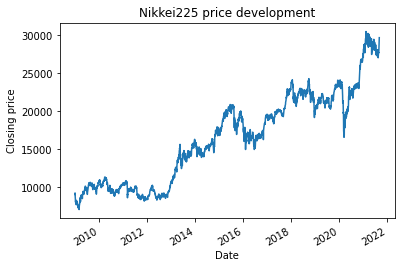

In [14]:
df = pdr.get_data_yahoo("^N225", start="2009-1-1", end="2021-9-07")['Adj Close']
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)

fig, ax = plt.subplots()
df.plot(ylabel='Closing price', title='Nikkei225 price development');

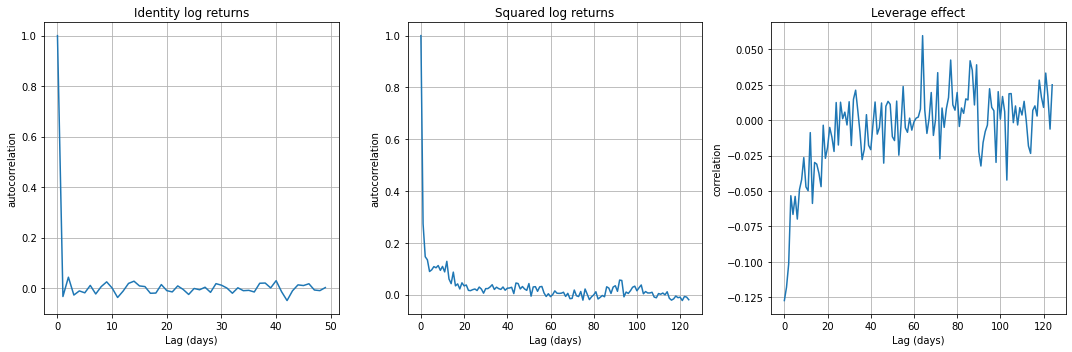

In [15]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

axs[0].plot(acf(log_returns, 50))
axs[0].set_title('Identity log returns')
axs[1].plot(acf(log_returns**2, 125))
axs[1].set_title('Squared log returns')
axs[2].plot(acf(log_returns, 125, le=True))
axs[2].set_title('Leverage effect')


for ax in axs: ax.grid(True)
plt.setp(axs, xlabel='Lag (days)')
plt.setp(axs[0:2], ylabel='autocorrelation')
axs[2].set_ylabel('correlation')
plt.tight_layout();

In [16]:
s1 = StandardScaler()
s2 = StandardScaler()
g1 = Gaussianize()

# receptive field size
rfs = 127

# pre-processing pipeline
log_returns_preprocessed = s2.fit_transform(g1.fit_transform(s1.fit_transform(log_returns)))
log_returns_rolled = rolling_window(log_returns_preprocessed, rfs)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

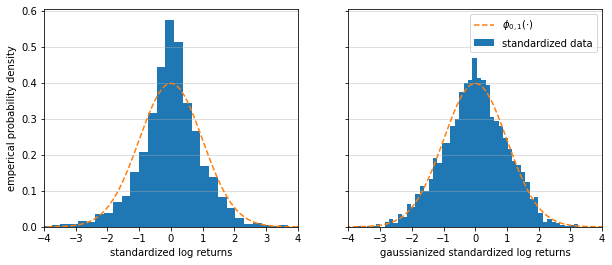

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4), sharey=True, sharex=True)
# We plot the distribution of log returns before and after the
# lambert W inverse transform respectively (both standardized). 
# We overlay it with a standard normal.

ax[0].hist(s1.transform(log_returns), bins=50, density=True)
x_range = np.linspace(*ax[0].get_xlim(), num=1000)
ax[0].plot(x_range, norm.pdf(x_range), linestyle='dashed')

ax[1].hist(log_returns_preprocessed, bins=50, density=True)
x_range = np.linspace(*ax[1].get_xlim(), num=1000)
ax[1].plot(x_range, norm.pdf(x_range), linestyle='dashed')

# add a grid to compare easily
ax[0].yaxis.grid(True, alpha=0.5)
ax[1].yaxis.grid(True, alpha=0.5);

ax[1].legend(['$\phi_{0, 1}(\cdot)$', 'standardized data'])
ax[0].set_ylabel('emperical probability density')
ax[0].set_xlabel('standardized log returns')
ax[1].set_xlabel('gaussianized standardized log returns')

ax[0].set_xlim(-4, 4)

plt.savefig('gaussianize.png', dpi=300);
files.download("gaussianize.png") 

In [18]:
dilations = 2**(np.arange(6))
n_filters = 100

discriminator = make_TCN(dilations, n_filters, 0, False, False, False, [1, rfs, 1])
generator = make_TCN(dilations, n_filters, 0, True, False, False, [1, None, 3])

In [19]:
class verboseGAN(GAN):
    # override the train hook method to print some metrics during training
    def train_hook(self, n_batch):
        if (n_batch + 1) % 500 == 0:
            y = self.generator(self.fixed_noise).numpy().squeeze()
            scores = []
            scores.append(np.linalg.norm(self.acf_real - acf(y.T, 250).mean(axis=1, keepdims=True)))
            scores.append(np.linalg.norm(self.abs_acf_real - acf(y.T**2, 250).mean(axis=1, keepdims=True)))
            scores.append(np.linalg.norm(self.le_real - acf(y.T, 250, le=True).mean(axis=1, keepdims=True)))
            print("\nacf: {:.4f}, acf_abs: {:.4f}, le: {:.4f}".format(*scores))
        
gan = verboseGAN(discriminator, generator, log_returns_rolled, lr_d=1e-4, lr_g=3e-5)

gan.acf_real = acf(log_returns_preprocessed, 250)
gan.abs_acf_real = acf(log_returns_preprocessed**2, 250)
gan.le_real = acf(log_returns_preprocessed, 250, le=True)

# noise that stays constant for displaying metrics
gan.fixed_noise = normal([128, 1, 4000 + rfs - 1, 3])

In [20]:
data = np.expand_dims(np.moveaxis(log_returns_rolled, 0,1), 1).astype('float32')
batch_size = 64
n_batches = 3000
additional_d_steps = 0

In [ ]:
# It may appear that I'm stopping while acf_abs is still significantly decreasing,
# but it has the tendency to increase after ~3000 steps.
gan.train(data, batch_size, n_batches, additional_d_steps)

In [ ]:
%%capture
generator.save('trained_generator_Nikkei225')
!zip -r trained_generator_Nikkei225.zip trained_generator_Nikkei225/ 

In [ ]:
files.download('trained_generator_Nikkei225.zip')

In [ ]:
noise = normal([128, 1, len(log_returns_preprocessed) + rfs - 1, 3])
y = generator(noise).numpy().squeeze()

y = (y - y.mean(axis=0))/y.std(axis=0)
y = s2.inverse_transform(y)
# unfortunately guassianize package doesnt support efficient column-wise transform
y = np.array([g1.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = s1.inverse_transform(y)

# some basic filtering, GAN has the tendency to produce extreme returns, caused by
# a tendency of the generator to produce heavier than normal tails, which is exercerbated
# by the lambert W transform. We filter out returns with more than twice the extremas of the
# original distribution.
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]

# center the log_paths for the picture
y -= y.mean()

#We retain a majority of samples
len(y)

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y, axis=1).T, alpha=0.75)
ax.set_title('{} generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

axs[0].plot(acf(log_returns, 100))
axs[0].plot(acf(y.T, 100).mean(axis=1))
axs[0].set_ylim(-0.1, 0.1)
axs[0].set_title('Identity log returns')
axs[1].plot(acf(log_returns**2, 100))
axs[1].set_ylim(-0.05, 0.5)
axs[1].plot(acf(y.T**2, 100).mean(axis=1))
axs[1].set_title('Squared log returns')
axs[2].plot(acf(log_returns, 100, le=True))
axs[2].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[2].set_ylim(-0.2, 0.1)
axs[2].set_title('Leverage effect')


for ax in axs: ax.grid(True)
plt.setp(axs, xlabel='days');